# 聚类

## 图像聚类实验

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image=cv2.imread('images/cluster_image.jpg')
image.shape

(440, 473, 3)

In [3]:
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


In [4]:
pixels=image.reshape((-1,3))
pixels=np.float32(pixels)
pixels.shape

(208120, 3)

In [11]:
## k-means 聚类
## finish condition: The number of iterations does not exceed 100,
## or the cluster center is moved by a very small value (here, 0.2)
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,100,0.2)

In [12]:
k=5
_, labels, (centers) = cv2.kmeans(data=pixels, K=k,
                                    bestLabels=None, criteria=criteria,
                                    attempts=10,
                                    flags=cv2.KMEANS_RANDOM_CENTERS)

In [15]:
centers=np.uint8(centers)


In [18]:
labels=labels.flatten()
segmented=centers[labels]
segmented=segmented.reshape(image.shape)

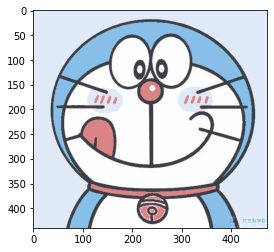

In [19]:
plt.imshow(segmented)
plt.show()

## 概念

聚类的核心概念：相似度与距离

### 层次聚类
1.聚合（自下而上）：聚合法开始将每个样本各自分裂到一个类，之后将相近的两类合并，建立一个新的类，重复此操作直到满足终止条件。

2.分裂（自上而下）：分裂法开始将所有样本分到一个类，之后将已有类中相距最远的样本分到两个新的类，重复此操作直到满足停止条件，得到层次化的类别。

聚合聚类需要预先确定下面三个要素：**距离或相似度**、**合并规则**、**停止条件**


In [ ]:
## 定义聚类数的节点
class ClusterNode:
    def __init__(self,vec,left=None,right=None,distance=-1,idnode=None,count=1):
        """
        :param vec: 保存两个数据聚类后形成新的中心
        :param left: 左节点
        :param right:  右节点
        :param distance: 两个节点的距离
        :param id: 用来标记哪些节点是计算过的
        :param count: 这个节点的叶子节点个数
        """
        self.vec = vec
        self.left = left
        self.right = right
        self.distance = distance
        self.id = idnode
        self.count = count
# def Euler_distance(point1,point2):
#     distance=0.0
#     for a ,b in zip(point1,point2):
#         distance+=np.linalg.norm(a-b)**2
#     return 
# 层次聚类（聚合法）

class Hierarchical:
    def __init__(self, k):
        self.k = k
        self.labels = None
        
    def fit(self, x):
        nodes = [ClusterNode(vec=v, id=i) for i, v in enumerate(x)]
        distances = {}
        point_num, feature_num = x.shape
        self.labels = [-1] * point_num
        currentclustid = -1
        while(len(nodes)) > self.k:
            min_dist = math.inf
            nodes_len = len(nodes)
            closest_part = None
            for i in range(nodes_len - 1):
                for j in range(i+1, nodes_len):
                    d_key = (nodes[i].id, nodes[j].id)
                    if d_key not in distances:
                        distances[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
                    d = distances[d_key]
                    if d < min_dist:
                        min_dist = d
                        closest_part = (i, j)
                        
            part1, part2 = closest_part
            node1, node2 = nodes[part1], nodes[part2]
            new_vec = [ (node1.vec[i] * node1.count + node2.vec[i] * node2.count ) / (node1.count + node2.count)
                        for i in range(feature_num)]
            new_node = ClusterNode(vec=new_vec,
                                   left=node1,
                                   right=node2,
                                   distance=min_dist,
                                   id=currentclustid,
                                   count=node1.count + node2.count)
            currentclustid -= 1
            del nodes[part2], nodes[part1]
            nodes.append(new_node)
            
        self.nodes = nodes
        self.calc_label()
        
    def calc_label(self):
        """
        调取聚类的结果
        """
        for i, node in enumerate(self.nodes):
            # 将节点的所有叶子节点都分类
            self.leaf_traversal(node, i)

    def leaf_traversal(self, node: ClusterNode, label):
        """
        递归遍历叶子节点
        """
        if node.left == None and node.right == None:
            self.labels[node.id] = label
        if node.left:
            self.leaf_traversal(node.left, label)
        if node.right:
            self.leaf_traversal(node.right, label)

### k-means 聚类

In [20]:
class K_Means(object):
    # k为簇的个数，tolerance‘中心误差点’，max_iter迭代次数
    def __init__(self,k=2,tolerance=0.0001,max_iter=300):
        self.k_=k
        self.tolerance_=tolerance
        self.max_iter_=max_iter
    def fit(self,data):
        self.centers_={}
        ## 1.顺序挑选 初始化聚类中心
        for i in range(self.k_):
            self.centers_[i]=data[i]
        ##2. 随机初始化
        inds=np.random.randint(low=0,high=len(data),size=self.k_)
        self.centers_=data[inds]
        #进行迭代
        for i in range(self.max_iter_):
            self.cls_={}
            for i in range(self.k_):
                self.cls_[i]=[]
            for feature in data:
                distances=[]
                for center in self.centers_:
                    #欧式距离
                    distances.append(np.linalg.norm(feature-self.centers_[center]))
                classfication=distances.index(min(distances))#分类结果
                self.cls_[classfication].append(feature)
            # 更新聚类中心
            prev_centers=dict(self.centers_)
            for c in self.cls_:
                self.centers_[c]=np.average(self.cls_[c],axis=0)
            # '中心点'是否在误差范围
            optimized=True
            for center in self.centers_:
                org_center=prev_centers[center]
                cur_center=self.centers_[center]
                if np.sum((cur_center-org_center)/cur_center*100)>self.tolerance_:
                    optimized=False
            #聚类中心不再进行大范围移动
            if optimized:
                break
    def predict(self,p_data):
        distances=[np.linalg.norm(p_data-self.centers_[center]) for center in self.centers_]## L2聚类
        index=distances.index(min(distances))
        return index